Wenn POS:
    Finde längsten Substring aus TK-Vokabular (Stämme)
    Präfix:
        Rekursiv längste Substrings bis komplett segmentiert
    Suffix:
        Rekursiv längste Substrings bis komplett segmentiert
    Rest:
        Aus atomarem Vokabular

LOAD FUNCTIONAL / LEXEMIC VOCAB

In [4]:
#import collections as cl
#from more_itertools import subslices
import text_utilities as tu
import wm_tokenizer
%load_ext autoreload
%autoreload 2

In [3]:
from HanTa import HanoverTagger as ht
from transformers import BertTokenizer
from tokenizers import pre_tokenizers

In [6]:
vocab = tu.VerbDict(path_to_functional_morphemes="../new_tokenizer/fun_vocab_raw.txt", path_to_lexemic_morphemes="../new_tokenizer/lex_vocab_raw.txt")

In [8]:
wmt = wm_tokenizer.WordmapTokenizer(vocab=vocab.lmfm,
        bert_pretokenizer = pre_tokenizers.BertPreTokenizer(),
        bert_tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased"),
        hantatagger = ht.HanoverTagger('morphmodel_ger.pgz'),
)

In [14]:
wmt.wordmap2tokenizer([], pos_tag="V", vocab=wmt.vocab, pt=wmt.bert_pretokenizer, tk=wmt.bert_tokenizer, tg=wmt.hantatagger)

{'input_ids': [[3,
   1278,
   11219,
   26963,
   9600,
   26970,
   7,
   4,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   

In [22]:
def tokenize(data: list):
    return wmt.wordmap2tokenizer(data, pos_tag="V", vocab=wmt.vocab, pt=wmt.bert_pretokenizer, tk=wmt.bert_tokenizer, tg=wmt.hantatagger)

In [11]:
wmt.bert_tokenizer.tokenize()

['weg', '##schm', '##eis', '##sen']

In [55]:
tk = "frisst"
subvocab = [i for i in lmfm.lmfm if i in tk]
segmentations = []

def segmenter(token, segments=None, start=0, stop=int):

    if segments is None:
        segments = []
    if start == stop:
        segmentations.append(segments)
    else:
        new_morpheme = [i for i in subvocab if token.startswith(i) and len(i)>1]
        for m in new_morpheme:
            rest = token[len(m):]
            start += len(m)
            segments.append(m)
            if len(rest) == 1:
                start = stop
                segments.append(rest)
                segmentations.append(segments)
                segments = segments[:-2]
                start -= (len(m) + 1)
            else:
                segmenter(token=rest, segments=segments.copy(), start=start, stop=stop)
                segments = segments[:-1]
                start -= len(m)

In [56]:
import timeit
begin = timeit.default_timer()

segs =  segmenter(token=tk, stop=len(tk))

end = timeit.default_timer()
print('Time: ', end - begin)


Time:  5.7225995988119394e-05


In [61]:
import numpy as np

In [59]:
# maximize weighted segmentations

def maximize_segments(segmentations):
    ws = dict()
    len_tk = len("".join(segmentations[0]))
    for s in segmentations:
        # ws[sum([lmfm[w] for w in s])/len(s)] = rel freqs / token length
        coverage = [len(i)/len_tk for i in s]  #  how much % of the word is covered by this morpheme
        morpheme_length = [len(i) for i in s]  #  how long is each morpheme
        rel_freq = [lmfm.lmfm[i] for i in s]  #  relative frequency of the morpheme in the vocab
        n_o_segs = [len(s) for i in s]
        #cover_rf = sum([i*j for i,j in zip(rel_freq, morpheme_length)])

        #lex_bias = sum([cov*mlen for cov, mlen in zip(coverage, morpheme_length)])
        lex_bias = sum([(np.tanh(mlen) / nsegs) for mlen, nsegs, freq in zip(morpheme_length, n_o_segs, rel_freq)])

        ws[lex_bias] = s

    wsk = list(ws.keys())
    wsm = np.median(wsk)
    return ws[min([i-wsm for i in wsk], key=abs)+wsm]
    #return ws[max(ws.keys())]

In [62]:
wsd = maximize_segments(segmentations)

In [63]:
segmentations

[['fris', 'st'], ['fri', 'ss', 't']]

43557

VOCABULARY; SPLIT WITH NP.PTP AND WEIGH UP LEXEMES

In [2]:
from scipy import stats as stats
from matplotlib import pyplot as pp
import numpy as np
import text_utilities as tu

In [27]:
lmfm = tu.VerbDict().lmfm
rfs = [lmfm[i] for i in lmfm.keys() if lmfm[i] != 0]
unis = list(set(rfs))
unis.sort(reverse=True)

zs = stats.zscore(unis)

scale = unis
umean = np.mean(scale)
umed = np.median(scale)
kurt = stats.kurtosis(scale)

In [28]:
unis

[0.06538234898843184,
 0.06295293132501473,
 0.017372920780308276,
 0.010766972325314532,
 0.009888246787482813,
 0.008135964685571326,
 0.007432984255305952,
 0.00658527255998594,
 0.004962214801873236,
 0.004026630552770053,
 0.003788857760180294,
 0.0035510849675905345,
 0.003339157043760532,
 0.0032616224374812626,
 0.0029411460648602825,
 0.0024552625321768618,
 0.002191644870827346,
 0.002098603343292223,
 0.0018298167081907558,
 0.001778126970671243,
 0.0016075508368568504,
 0.001436974703042458,
 0.001385284965522945,
 0.0013491021492592862,
 0.0012612295954761142,
 0.0010131188553824523,
 0.0009821050128707447,
 0.0009665980916148907,
 0.0007598391415368393,
 0.0006564596664978135,
 0.0006202768502341545,
 0.0006151078764822033,
 0.0005789250602185442,
 0.0005220663489470801,
 0.00047037661142756716,
 0.0004393627689158594,
 0.00040834892640415174,
 0.00036182816263659014,
 0.00032047637262097985,
 0.0002894625301092721,
 0.0002842935563573208,
 0.00027912458260536955,
 0.0002

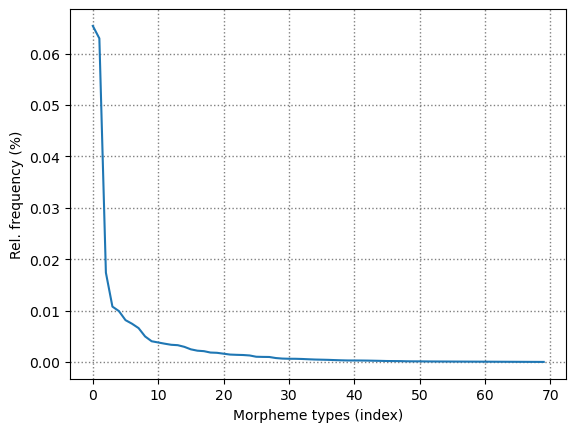

In [42]:
qq = np.quantile(scale, q=[0.05, 0.7])
pp.plot(scale)

ax = pp.gca()

max_value = max(unis)
min_value = min(unis)
number_of_steps = 1
l = np.arange(min_value, max_value+1, number_of_steps)
# ax.set(xticks=[0 for x in l], xticklabels=l)

# pp.plot([qq[0] for i in scale])
# pp.plot([qq[1] for i in scale])
pp.xlabel('Morpheme types (index)')
pp.ylabel('Rel. frequency (%)')
pp.grid(color='gray', linestyle=':', linewidth=1)
#pp.xticks(np.arange(stop=len(scale),step=1), labels=scale)

In [ ]:
lexemes = {k:lmfm[k] for k in lmfm if qq[0]<lmfm[k]<qq[1]}
lexemes

In [ ]:
for i in lexemes:
    if len(i) > 7:
        print(i)

TRY BERT TOKENIZATION

1) format own vocab and add to pretrained tokenize via tokenizer.add_tokens
später: separat ein vocab als weighted dict in dem lexeme (zipf graph slicen, siehe oben) high weight sind, morpheme in fun aus lex vocab rausnehmen
2) über satz gehen und verben finden: verben mit eigenem tokenizer (wenn stem in token, aber: vocab muss überreinstimmen) segmentieren: satz ohne verben an großen pre_trained weitergeben: verben wieder einfügen
3) encoded

In [4]:

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")
# tokenizer.add_tokens(HIER BEIDE SLICES: set(lex+fun))

In [191]:
sample = 'Ich möchte gerne verbessern wie du segmentierst '
encoding = tokenizer.encode(sample)
print(encoding)
print(tokenizer.convert_ids_to_tokens(encoding))

[3, 1671, 5513, 6812, 11866, 246, 4547, 4893, 26908, 3758, 5523, 26901, 4]
['[CLS]', 'Ich', 'möchte', 'gerne', 'verbessern', 'wie', 'du', 'se', '##g', '##ment', '##iers', '##t', '[SEP]']


SPLIT SENTENCE TO TOKENIZE INTO LEX TOKENS (-> to own tokenizer) AND REST SENTENCE (-> pass on to pretrained)

In [29]:

from HanTa import HanoverTagger as ht
import regex as re
from wm_tokenizer import SequenceTokenizer
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")
tagger = ht.HanoverTagger('morphmodel_ger.pgz')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
sentence = 'Der wissende Programmierer möchte gerne essen was in der Truhe versteckt wurde'

In [192]:

verbs = [(1, i[0]) for i in tagger.tag_sent(sentence.split(" ")) if i[2].startswith("V")]

divisions = re.split("("+"|".join(verbs)+")", sentence)

TypeError: sequence item 0: expected str instance, tuple found

In [113]:
pos_tag = "V"
encoding = []

for i in sentence.split(" "):
    if tagger.analyze(i)[1].startswith(pos_tag):
        wmt = SequenceTokenizer(vocab=lmfm, target=i) # wordmap tokenizer here
        tokenizer_format = [wmt.maxed[0]]+["##" + i for i in wmt.maxed[1:]]
        tokenizer.add_tokens(tokenizer_format)
        encoding.extend(tokenizer_format)
    else:
        encoding.extend(tokenizer.tokenize(i))
print(encoding)
tks = tokenizer.encode(encoding)
ids = tokenizer.convert_ids_to_tokens(tks)
print(tks)
print(ids)

['Der', 'wissen', '##de', 'Programm', '##ierer', 'möch', '##te', 'gerne', 'ess', '##en', 'was', 'in', 'der', 'Tru', '##he', 've', '##rst', '##eck', '##t', 'wur', '##de']
[3, 233, 5029, 57, 3966, 9175, 30000, 26, 6812, 30001, 7, 961, 50, 21, 12508, 208, 25468, 30002, 5915, 26901, 159, 57, 4]
['[CLS]', 'Der', 'wissen', '##de', 'Programm', '##ierer', 'möch', '##te', 'gerne', 'ess', '##en', 'was', 'in', 'der', 'Tru', '##he', 've', '##rst', '##eck', '##t', 'wur', '##de', '[SEP]']


In [115]:
a = [wmt.maxed[0]].extend(["##" + i for i in wmt.maxed[1:]])

In [236]:
t = SequenceTokenizer(vocab=lmfm, target="bezahlen")
t.segmentations

[['be', 'zahl', 'en'],
 ['bezah', 'le', 'n'],
 ['bezah', 'len'],
 ['bezahl', 'en']]

TEST THE WHOLE TOKENIZATION PIPELINE

In [9]:
import wm_tokenizer
import text_utilities
from HanTa import HanoverTagger as ht
from transformers import BertTokenizer
from tokenizers import pre_tokenizers


tu = text_utilities.VerbDict("../new_tokenizer/fun_vocab_raw.txt", "../new_tokenizer/lex_vocab_raw.txt")

wmt = wm_tokenizer.WordmapTokenizer(
    bert_pretokenizer=pre_tokenizers.BertPreTokenizer(),
    bert_tokenizer=BertTokenizer.from_pretrained("bert-base-german-cased"),
    hantatagger=ht.HanoverTagger('morphmodel_ger.pgz'),
    vocab=tu.lmfm)

tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

GENERATE TOKEN_TYPE_IDS + ATTENTION_MASK + OVERFLOWING TOKEN

In [41]:
sentence_tokens = ['Der', 'wissen', '##de', 'Programm', '##ierer', 'möch', '##te', 'gerne', 'ess', '##en', 'was', 'in', 'der', 'Tru', '##he', 've', '##rst', '##eck', '##t', 'wur', '##de']
sentence_tokenids = [3, 233, 5029, 57, 3966, 9175, 30000, 26, 6812, 30001, 7, 961, 50, 21, 12508, 208, 25468, 30002, 5915, 26901, 159, 57, 4]
sentence_tokens2 = " test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein test ein ".join(sentence_tokens)

test = tokenizer.encode_plus(sentence_tokens2, return_token_type_ids=True, return_attention_mask=True, return_overflowing_tokens=True, max_length=510)

510

GET PRETOKENIZED SENTENCE FROM BERT PRETOKENIZER

In [ ]:
from tokenizers import pre_tokenizers
pret = pre_tokenizers.BertPreTokenizer()
sent =  "Das ist der Testsatz, der alles; ja ALLES enthalten könnte?! ™⅜"
pretokenized = [i[0] for i in pret.pre_tokenize_str(sent)]

In [69]:
len(lmfm.lmfm)

43700